<a id='summary'></a>
# Census Lyon
* Preprocessing to get a clean population sample
* census from https://www.insee.fr/fr/statistiques/3625223
* iris from https://insee.fr/fr/information/2383182
* Some IRIS are censored to the canton-ville, but canton-ville are really coarse (see the census notebook in dataviz)
* So we use the mobpro-mobsco (lil-1475 and lil-1476 in quetelet) to have a commune-level census

## Summary
* [Loading GIS](#gis)
    * [IRIS](#iris)
    * [Communes](#communes)
    
    
* [Census](#census)
    * [Spatial filtering](#census_filtering)
    * [Preprocessing](#census_preprocessing)
    * [Integerization and sub-sampling](#census_integerization)
    * [Renaming](#census_renaming)
    
    
* [Mobsco & mobpro](#mob)
    * [Spatial filtering](#mob_filter)
    * [Preprocessing](#mob_preprocessing)
    * [Renaming](#mob_communes)
    * [Integerization and sub-sampling](#mob_integerization)
    
    
* [Merging sources](#merge)
    * [Cleaning](#cleaning)
    * [Marginals](#marginals)
    * [Exporting](#exporting)
    
    
* [Merging GIS](#gis_merge)
    * [Getting nearest neighbors](#nearest_neighbors)
    * [Exporting GIS](#gis_export)
    
    
* [dictionnaire final](#dico)



In [1]:
import geopandas as gpd
import json
import numpy as np
import os
import pandas as pd

from utils.chrono import Chrono
from utils.binage import bin_age
import matplotlib.pyplot as plt



with open('config.json', 'r') as config_path:
    config = json.load(config_path)
    
sample_frac = config['census_sample_frac']


census_out_path = os.path.join(config['outdata_dir']['path'], 
                         config['outdata_dir']['synthpop_filename'])



<a id='gis'></a>
# Loading GIS
* The GIS for census is IRIS
* Some IRIS are censored to the canton-ville, but canton-ville are really coarse (see the census notebook in dataviz)
* So we use the mobpro-mobsco to have a commune-level census
* [back to summary](#summary)

<a id='iris'></a>
## IRIS
* Map of IRIS already cropped to the study area

In [2]:
iris_path = os.path.join(config['data_dir']['path'], 
                         config['data_dir']['iris_map'])

iris = gpd.read_file(iris_path)
iris = iris.set_crs('epsg:3035').drop(columns=['wkt'])
iris['frac_area'] = iris['frac_area'].astype(float)
display(iris.head())

,INSEE_COM,CODE_IRIS,frac_area,geometry
0,01043,10430000,1.000,"POLYGON ((3932177.079 2534999.377, 3932120.907..."
1,01049,10490000,0.903,"POLYGON ((3935987.169 2537653.876, 3935944.619..."
2,01249,12490102,1.000,"POLYGON ((3929978.628 2538320.181, 3930014.127..."
3,01249,12490103,0.872,"POLYGON ((3927599.476 2536652.223, 3927568.423..."
4,01249,12490101,1.000,"POLYGON ((3927633.876 2536580.935, 3927634.670..."


In [3]:
# for viz

# 
# import contextily as ctx
# 
# fig, ax = plt.subplots(figsize=(20, 20))
# #iris.plot(ax=ax, alpha=0.9, edgecolor='w',linewidth=1.5)
# 
# 
# iris.boundary.plot(ax=ax,color='k',linewidth=1)
# ctx.add_basemap(ax, crs='epsg:3035', source=ctx.providers.OpenStreetMap.Mapnik, zoom=13)
# #ctx.add_basemap(ax, crs='epsg:3035', source=ctx.providers.Stamen.Watercolor)
# #ctx.add_basemap(ax, crs='epsg:3035', source=ctx.providers.OpenTopoMap) # no
# #ctx.add_basemap(ax, crs='epsg:3035', source=ctx.providers.Stamen.Toner) # no
# #ctx.add_basemap(ax, crs='epsg:3035', source=ctx.providers.Stamen.TonerLite) # no
# #ctx.add_basemap(ax, crs='epsg:3035', source=ctx.providers.Stamen.Terrain)
# #ctx.add_basemap(ax, crs='epsg:3035', source=ctx.providers.Stamen.TerrainBackground) # hmpf
# 
# ax.axis('off')
# #ax.set_title('iris')
# plt.tight_layout()
# plt.savefig('/Users/benoit/Desktop/gismap.pdf',dpi=200)
# plt.show()

<a id='communes'></a>
## Communes

In [4]:
communes_path = os.path.join(config['data_dir']['path'], 
                         config['data_dir']['communes_map'])

communes = gpd.read_file(communes_path).set_crs('epsg:3035').drop(columns=['wkt'])
communes['frac_area'] = communes['frac_area'].astype(float)


<a id='census'></a>
# Census
* **SEXE** : 1:homme, 2:femme
* **TRANS** : Mode de transport principal le plus souvent utilisé pour aller travailler
    * **1** : Pas de transport
    * **2** : Marche à pied
    * **3** : Deux roues
    * **4** : Voiture, camion, fourgonnette 
    * **5** : Transports en commun
    * **Z** : Sans objet
* **VOIT** : Nombre de voitures du ménage
    * **0** : Aucune voiture
    * **1** : Une seule voiture
    * **2** : Deux voitures
    * **3** : Trois voitures ou plus
    * **X** : Logement ordinaire inoccupé 
    * **Z** : Hors logement ordinaire
* **IPONDI** : Poids de l'individu
* **INPER** : Nombre de personnes du ménage
* **CS1** : Catégorie socioprofessionnelle en 8 postes
    * **1** : Agriculteurs exploitants
    * **2** : Artisans, commerçants et chefs d'entreprise
    * **3** : Cadres et professions intellectuelles supérieures 4 : Professions Intermédiaires
    * **5** : Employés
    * **6** : Ouvriers
    * **7** : Retraités
    * **8** : Autres personnes sans activité professionnelle
* **ETUD** : inscription dans un lieu d'étude
    * **1** : oui
    * **2** : non
* **STOCD** : Statut d'occupation détaillé du logement
    * **00** : Logement ordinaire inoccupé
    * **10** : Propriétaire
    * **21** : Locataire ou sous-locataire d'un logement loué vide non HLM
    * **22** : Locataire ou sous-locataire d'un logement loué vide HLM
    * **23** : Locataire ou sous-locataire d'un logement loué meublé ou d'une chambre d'hôtel
    * **30** : Logé gratuitement
    * **ZZ** : Hors logement ordinaire

In [5]:
# 00:03:00
census_path = os.path.join(config['data_dir']['path'], config['data_dir']['census'])

c=Chrono('Loading...')
census = pd.read_csv(census_path, sep=';', low_memory=False)
c.tprint('{} rows'.format(len(census)))
c.done()
census.head()

06:41:58	Loading...
00:02:19	4788053 rows
00:02:19	Work complete !


,CANTVILLE,NUMMI,ACHLR,AEMMR,AGED,AGER20,AGEREV,AGEREVQ,ANAI,ANEMR,...,TP,TRANS,TRIRIS,TYPC,TYPFC,TYPL,TYPMC,TYPMR,VOIT,WC
0,0101,1,1,9,65,64,64,60,1948,00,...,Z,Z,ZZZZZZ,3,Z,2,1,12,1,Z
1,0101,2,5,9,21,24,20,20,1995,01,...,Z,Z,ZZZZZZ,3,Z,2,1,11,1,Z
2,0101,3,4,6,70,79,69,65,1944,05,...,Z,Z,ZZZZZZ,2,2,1,4,44,1,Z
3,0101,3,4,6,70,79,69,65,1944,05,...,Z,Z,ZZZZZZ,2,2,1,4,44,1,Z
4,0101,4,3,9,53,54,52,50,1962,02,...,1,4,ZZZZZZ,2,Z,2,1,11,1,Z


In [6]:
for dept_str in ['69', '01', '38']:
    print('{} individuals in dept {} ({:.0f} with INSEE rescaling coefs)'.format(len(census[census['DEPT']==dept_str]), 
                                                                             dept_str,
                                                                            census[census['DEPT']==dept_str]['IPONDI'].sum()))

588897 individuals in dept 69 (1821882 with INSEE rescaling coefs)
148313 individuals in dept 01 (631830 with INSEE rescaling coefs)
338902 individuals in dept 38 (1250830 with INSEE rescaling coefs)


<a id='census_filtering'></a>
## Filtering agents in the study area

In [7]:
c = Chrono('{} rows ({:.1f} with coefs)'.format(len(census), census['IPONDI'].sum()))
census = census.merge(iris[['CODE_IRIS','frac_area', 'INSEE_COM']], left_on='IRIS', right_on='CODE_IRIS')
c.tprint('{} rows after filtering ({:.1f} with coefs)'.format(len(census), census['IPONDI'].sum()))
census['IPONDI'] = census['IPONDI'] * census['frac_area']
c.tprint('{} rows after cropping iris ({:.1f} with coefs)'.format(len(census), census['IPONDI'].sum()))
census = census.drop(columns=['CODE_IRIS', 'frac_area'])
c.done()

06:44:22	4788053 rows (15101401.9 with coefs)
00:00:01	465516 rows after filtering (1296457.3 with coefs)
00:00:01	465516 rows after cropping iris (1284113.1 with coefs)
00:00:01	Work complete !


<a id='census_preprocessing'></a>
## Preprocessing

### Main transport mode to go to work
* Same mapping as EGT except that we add a **-1** modality for people with no transport to go to work (either no work or work from home):
    * **-1** : Not applicable
    * **0** : Walking
    * **1** : Bicycle
    * **2** : Private motorized
    * **3** : Public transport
* Note that census does not make the difference between 2-wheels and bikes, so we consider 2-wheels to mean motorized and census has no bike at all.
* There is a lot of `not applicable`, but maybe it's normal, just means that a lot of people don't go to work

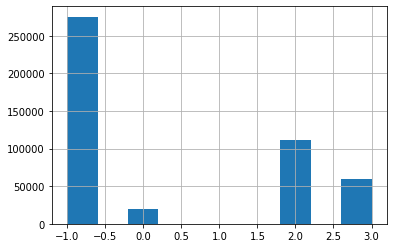

In [8]:
census['main_transport_work'] = census['TRANS'].replace({'1':-1, '2':0, '3':2, '4':2, '5':3, 'Z':-1})
census['main_transport_work'].hist()
plt.show()

### Home status
* For lyon income is not availble in EGT
* so we use home status to have a small idea of wealth :
    * **0** : propriétaire
    * **1** : locataire HLM
    * **2** : locataire non HLM
* From modalities in STOCD, we consider that `logé gratuitement` means you are close to the owner, so we map it to `propriétaire`.
* `Hors logement ordinaire` is probably closest to `locataire HLM` as I guess that if you are neither owner, tenent, or housed graciously, you probably have no money.

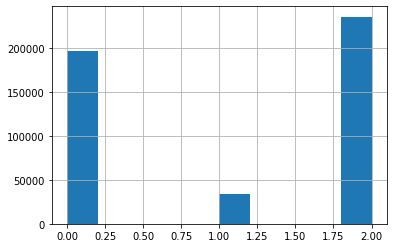

In [9]:
census['home_status'] = census['STOCD'].replace({'00':0, '10':0, '21':2, '22':2, '23':1, '30':0, 'ZZ':1})
census['home_status'].hist()
plt.show()

### Household has a car

In [10]:
census.loc[census['VOIT']=='Z', 'VOIT'] = np.nan
census['has_car'] = census['VOIT'].fillna(0)
census['has_car'] = census['has_car'].astype(int)
census['has_car'] = (census['has_car']>0).astype(int)



### Age
* **0** : 0-17
* **1** : 18-29
* **2** : 30-59
* **3** : 60+

In [11]:
census['age'] = bin_age(census['AGEREV'])

* Drop rows with missing age

In [12]:
to_drop = census[census['age'].isna()].index
print('age missing : dropping {} rows out of {}'.format(len(to_drop), len(census)))
census = census.drop(to_drop)

age missing : dropping 7044 rows out of 465516


### Gender
* **0** : male
* **1** : female

In [13]:
census['gender'] = census['SEXE'].replace({1:0, 2:1})

### Occupation
* **0** : inactif, chômeur
* **1** : Agriculteurs exploitants
* **2** : Artisans, commerçants et chefs d'entreprise
* **3** : Cadres
* **4** : Professions Intermédiaires
* **5** : Employés
* **6** : Ouvriers
* **7** : Élèves, étudiants
* **8** : Retraité

In [14]:
def cs1_to_occupation(cs1, is_student=False):
    if is_student:
        return 7
    elif cs1==7:
        return 8
    elif cs1==8:
        return 0
    return cs1

In [15]:
c = Chrono('occupation...')
census['occupation'] = census.apply(lambda r:cs1_to_occupation(r['CS1'], r['ETUD']==1), axis=1)
c.done()

06:44:26	occupation...
00:00:05	Work complete !


<a id='census_integerization'></a>
## Integerization and sub-sampling
* Integerize the coefs of the pop via **TRS** (Truncation, Replication and Sampling) Lovelace2013, summarized in Yameogo2021)
* Basically consider considers the decimal part of the coefs is a probability of presence of a full agent
* Alternative : **proportional probabilities**, where we consider coefs a potential to draw from, and we draw the right number of agents

In [16]:
rng = np.random.default_rng(seed=42)

def TRS(coef_col):
    """
    integerize by considering the integer part is a fixed number 
    and the decimal part is a probability of existence
    """
    return np.floor(coef_col) + (rng.random(size=len(coef_col)) <= coef_col%1)  

def subsample(coef_col, sample_frac=1):
    """
    subsample the data with each agent have a sample_frac proba of being kept
    sum of bernouilli is a binomial so that's it
    """
    return rng.binomial(coef_col, sample_frac)

census['coef'] = subsample(TRS(census['IPONDI']), sample_frac=sample_frac)



<a id='census_renaming'></a>
## Renaming

In [17]:
renaming_dict = {
    'IRIS':'iris_or_commune',
    'gender':'gender',
    'has_car':'has_car',
    'occupation':'occupation',
    'age':'age',
    'coef':'coef',
    'IPONDI':'IPONDI'
}
cols = list(renaming_dict.values())
census = census.rename(columns=renaming_dict)
census[cols].head()

,iris_or_commune,gender,has_car,occupation,age,coef,IPONDI
0,690270102,0,1,8,3,3,3.066042
1,690270102,1,1,8,3,3,3.066042
2,690270102,0,1,7,1,3,2.998543
3,690270102,0,1,4,2,3,2.998543
4,690270102,1,1,0,2,3,2.998543


<a id='mob'></a>
# Mobpro (lil-1476) & Mobsco (lil-1475)
comme 'migration pendulaire', mais c'est un échantillon de population et il y a le mode de transport principal. Quelques variables pouvant être intéressantes : 
* **COMMUNE** : Département et commune du lieu de résidence
* **DCLT** :  Département, commune et arrondissement municipal (Paris, Lyon, Marseille) du lieu de travail
* **AGEREVQ** : Âge quinquennal en années révolues
* **CS1** : Catégorie socioprofessionnelle en 8 postes
* **DIPL** : Diplôme le plus élevé
* **IPONDI** : Poids de l'individu
* **NA5** : Activité économique regroupée en 5 postes
* **NPERR** : Nombre de personnes du ménage (regroupé)
* **SEXE** : Sexe
* **STAT** : Statut professionnel
* **TP** : Temps de travail
* **TRANS** : Mode de transport principal le plus souvent utilisé pour aller travailler
    * **1** : Pas de transport
    * **2** : Marche à pied (ou rollers, patinette)
    * **3** : Vélo (y compris à assistance électrique)
    * **4** : Deux-roues motorisé
    * **5** : Voiture, camion, fourgonnette
    * **6** : Transports en commun
    * **Z** : Sans objet
* **VOIT** : Nombre de voitures du ménage
* **CS1** : Cat socio-pro
    * **1** : Agriculteurs exploitants
    * **2** : Artisans, commerçants et chefs d'entreprise
    * **3** : Cadres et professions intellectuelles supérieures
    * **4** : Professions Intermédiaires
    * **5** : Employés
    * **6** : Ouvriers
    * **7** : Retraités
    * **8** : Autres personnes sans activité professionnelle
* **STOCD** : Statut d'occupation détaillé du logement
    * **00** : Logement ordinaire inoccupé
    * **10** : Propriétaire
    * **21** : Locataire ou sous-locataire d'un logement loué vide non HLM
    * **22** : Locataire ou sous-locataire d'un logement loué vide HLM
    * **23** : Locataire ou sous-locataire d'un logement loué meublé ou d'une chambre d'hôtel
    * **30** : Logé gratuitement
    * **ZZ** : Hors logement ordinaire
    

### pour mobsco :
AGEREV10
* **02** : 2 ans
* **03** : 3 ans
* **04** : 4 ans
* **05** : 5 ans
* **06** : 6-10 ans
* **11** : 11-14 ans
* **15** : 15-17 ans
* **18** : 18-24 ans
* **25** : 25-29 ans
* **30** : 30 ans ou plus

### pour mobpro :
* **AGEREVQ** : n means age is between n and n+4

In [18]:
c=Chrono('reading mobpro...')
mobpro_path = os.path.join(config['data_dir']['path'], config['data_dir']['mobpro'])
mobpro = pd.read_csv('../../data/lil-1476/csv/fd_mobpro_2018.csv', sep=';', dtype = {'COMMUNE':str, 'DCLT':str}, low_memory=False)

c.tprint('reading mobsco...')
mobsco_path = os.path.join(config['data_dir']['path'], config['data_dir']['mobsco'])
mobsco = pd.read_csv('../../data/lil-1475/csv/fd_mobsco_2018.csv', sep=';', dtype = {'COMMUNE':str, 'DCETUF':str}, low_memory=False)

c.done()

06:44:32	reading mobpro...
00:00:42	reading mobsco...
00:00:55	Work complete !


<a id='mob_filtering'></a>
## Spatial filtering
* Keeping only communes in the study area
* weighting the scaling coeficients by the fraction of area effectively in the study zone
* Keeping only communes that have people at the iris level

In [19]:
communes_handled = census['INSEE_COM'].unique()
communes_handled = np.concatenate([communes_handled, ['69123']])  # adding code for Lyon
communes_handled

array(['69027', '69043', '69277', '69287', '69291', '69290', '69282',
       '69259', '69149', '69256', '69244', '69387', '69034', '69386',
       '69384', '69389', '69266', '69383', '69385', '69029', '69382',
       '69381', '69388', '69286', '69275', '69152', '69273', '69072',
       '69089', '69202', '69069', '69040', '69199', '69100', '69081',
       '69204', '69142', '69283', '69191', '69088', '69194', '69279',
       '69276', '69271', '69123'], dtype=object)

In [20]:

c = Chrono('filtering mobpro...')
mobpro = mobpro[mobpro['COMMUNE'].str[:2].isin(['01', '38', '69'])]
mobpro = mobpro[mobpro['DCLT'].str[:2].isin(['01', '38', '69'])]

mobpro = mobpro.merge(communes[['insee','frac_area']], left_on = 'COMMUNE', right_on='insee')
mobpro = mobpro[~mobpro['COMMUNE'].isin(communes_handled)]
mobpro['IPONDI'] = mobpro['IPONDI'] * mobpro['frac_area']

c.write('{} rows after cropping iris ({:.1f} with coefs)'.format(len(mobpro), mobpro['IPONDI'].sum()))
mobpro = mobpro.drop(columns=['insee', 'frac_area'])

c.write('filtering mobsco...')
mobsco = mobsco[mobsco['COMMUNE'].str[:2].isin(['01', '38', '69'])]
mobsco = mobsco[mobsco['DCETUF'].str[:2].isin(['01', '38', '69'])]

mobsco = mobsco.merge(communes[['insee','frac_area']], left_on = 'COMMUNE', right_on='insee')
mobsco = mobsco[~mobsco['COMMUNE'].isin(communes_handled)]
mobsco['IPONDI'] = mobsco['IPONDI'] * mobsco['frac_area']

c.write('{} rows after cropping iris ({:.1f} with coefs)'.format(len(mobsco), mobsco['IPONDI'].sum()))
mobsco = mobsco.drop(columns=['insee', 'frac_area'])

c.done()

06:45:27	filtering mobpro...
00:00:03	14150 rows after cropping iris (44551.2 with coefs)
00:00:03	filtering mobsco...
00:00:06	7962 rows after cropping iris (25063.5 with coefs)
00:00:06	Work complete !


<a id='mob_preprocessing'></a>
## Preprocessing variables

In [21]:
mobpro.loc[mobpro['VOIT']=='Z', 'VOIT'] = np.nan
mobpro['has_car'] = mobpro['VOIT'].fillna(0)
mobpro['has_car'] = mobpro['has_car'].astype(int)
mobpro['has_car'] = (mobpro['has_car']>0).astype(int)
mobpro['age'] = bin_age(mobpro['AGEREVQ'])
mobpro['gender'] = mobpro['SEXE'].replace({1:0, 2:1})
mobpro['occupation'] = mobpro.apply(lambda r:cs1_to_occupation(r['CS1']), axis=1)
mobpro['main_transport_work'] = mobpro['TRANS'].replace({'1':-1, '2':0, '3':2, '4':2, '5':3, 'Z':-1})
mobpro['home_status'] = mobpro['STOCD'].replace({'00':0, '10':0, '21':2, '22':2, '23':1, '30':0, 'ZZ':1})



In [22]:
mobsco.loc[mobsco['VOIT']=='Z', 'VOIT'] = np.nan
mobsco['has_car'] = mobsco['VOIT'].fillna(0)
mobsco['has_car'] = mobsco['has_car'].astype(int)
mobsco['has_car'] = (mobsco['has_car']>0).astype(int)
mobsco['age'] = bin_age(mobsco['AGEREV10'])
mobsco['gender'] = mobsco['SEXE'].replace({1:0, 2:1})
mobsco['occupation'] = 7
mobsco['main_transport_work'] = -1
mobsco['home_status'] = mobsco['STOCD'].replace({'00':0, '10':0, '21':2, '22':2, '23':1, '30':0, 'ZZ':1})

<a id='mob_integerization'></a>
## Integerization and sub-sampling


In [23]:
mobpro['coef'] = subsample(TRS(mobpro['IPONDI']), sample_frac=sample_frac)
print(mobpro['coef'].sum())

mobsco['coef'] = subsample(TRS(mobsco['IPONDI']), sample_frac=sample_frac)
print(mobsco['coef'].sum())

44541
25039


<a id='mob_renaming'></a>
## Renaming

In [24]:
renaming_dict = {'COMMUNE':'iris_or_commune'}

mobpro = mobpro.rename(columns=renaming_dict)
mobsco = mobsco.rename(columns=renaming_dict)

<a id='merge'></a>
# Filtering & merging IRIS census & Communes census


In [25]:
cols = ['iris_or_commune', 'gender', 'has_car', 'occupation', 'age', 
        'coef', 'IPONDI', 'home_status', 'main_transport_work']
census_commune = pd.concat([census[cols], mobpro[cols],mobsco[cols]])
census_commune.head()

,iris_or_commune,gender,has_car,occupation,age,coef,IPONDI,home_status,main_transport_work
0,690270102,0,1,8,3,3,3.066042,0,-1
1,690270102,1,1,8,3,3,3.066042,0,-1
2,690270102,0,1,7,1,3,2.998543,0,2
3,690270102,0,1,4,2,3,2.998543,0,2
4,690270102,1,1,0,2,3,2.998543,0,-1


<a id='marginals'></a>
## Marginals
* Get the total number of agents for each modality
* /!\ Use IPONDI, not coef_sampled

In [26]:
marginal_out_path = os.path.join(config['outdata_dir']['path'], 
                         config['outdata_dir']['socioeco_marginals_filename'])

marginals = census_commune.groupby(['age', 'gender', 'has_car', 'occupation', 'iris_or_commune'])['IPONDI'].sum().reset_index()
marginals = marginals[marginals['IPONDI']>0]
marginals.to_csv(marginal_out_path, index=False)

<a id='cleaning'></a>
## Cleaning

In [27]:
c = Chrono('Dropping agents that have not been sampled (coef=0)...')
to_drop = census_commune[census_commune['coef']==0].index
len_before = len(census_commune)
census_commune = census_commune.drop(to_drop)
census_commune = census_commune.drop(columns=['IPONDI'])
c.tprint('Dropped {} rows out of {} ({:.0f}%)'.format(len(to_drop),len_before, 
                                                       100*len(to_drop)/len_before))
c.tprint('Dropping rows with missing value...')
len_before = len(census_commune)
census_commune = census_commune.dropna()
nb_drop = len_before - len(census_commune)
c.tprint('Dropped {} rows out of {} ({:.0f}%)'.format(nb_drop, len_before, 
                                                       100*nb_drop/len_before))

c.tprint('Flattening to get 1 row per agent...')
census_commune = (census_commune
                  .iloc[np.repeat(np.arange(len(census_commune)), census_commune['coef'])]
                  .reset_index(drop=True)
                  .drop(columns=['coef']))
c.done()
c.tprint('{} rows'.format(len(census_commune)))

06:45:34	Dropping agents that have not been sampled (coef=0)...
00:00:00	Dropped 5569 rows out of 480584 (1%)
00:00:00	Dropping rows with missing value...
00:00:00	Dropped 0 rows out of 472101 (0%)
00:00:00	Flattening to get 1 row per agent...
00:00:00	Work complete !
00:00:00	1325654 rows


<a id='exporting'></a>
## Exporting

In [28]:
census_commune = census_commune.dropna()
census_commune.to_csv(census_out_path, index=False)
census_commune.head()

,iris_or_commune,gender,has_car,occupation,age,home_status,main_transport_work
0,690270102,0,1,8,3,0,-1
1,690270102,0,1,8,3,0,-1
2,690270102,0,1,8,3,0,-1
3,690270102,1,1,8,3,0,-1
4,690270102,1,1,8,3,0,-1


<a id='dico'></a>
## Dictionnaire final
* **iris_or_commune** : code IRIS or code COMMUNE
* **gender**
    * **0** : male
    * **1** : female
* **has_car**
    * **0** : household has no car
    * **1** : household has a car
* **occupation**
    * **0** : inactif, chômeur
    * **1** : Agriculteurs exploitants
    * **2** : Artisans, commerçants et chefs d'entreprise
    * **3** : Cadres
    * **4** : Professions Intermédiaires
    * **5** : Employés
    * **6** : Ouvriers
    * **7** : Élèves, étudiants
    * **8** : Retraité
* **age**
    * **0** : 0-17
    * **1** : 18-29
    * **2** : 30-59
    * **3** : 60+
* **coef** : integerized, sampled coefficient



### notable missing vars
* **license**
* **income**

<a id='gis_merge'></a>
# Merging GIS
* [back to summary](#summary)

* Getting communes that are used in census commune (MOBPRO and MOBSCO):

In [29]:
communes_in_census = communes[communes['insee'].isin(census_commune['iris_or_commune'].unique())].copy()
communes_in_census['is_iris'] = False
communes_in_census = communes_in_census.rename(columns={'insee':'iris_or_commune'})
communes_in_census['commune'] = communes_in_census['iris_or_commune']  # useful for some merging with commune datas
communes_in_census.head()

,iris_or_commune,frac_area,geometry,is_iris,commune
0,01043,1.000,"POLYGON ((3931567.736 2535603.294, 3931455.673...",False,01043
1,01049,0.903,"POLYGON ((3931819.419 2541777.411, 3931843.795...",False,01049
2,01249,0.901,"POLYGON ((3930627.132 2534580.113, 3930588.941...",False,01249
3,01262,0.161,"POLYGON ((3931728.804 2541776.577, 3931683.836...",False,01262
4,01275,1.000,"POLYGON ((3926169.735 2534938.133, 3926094.500...",False,01275


* Getting IRIS for agents that are not inn census commune:

In [30]:
iris_in_census = iris[~iris['INSEE_COM'].isin(communes_in_census['iris_or_commune'])].copy()
iris_in_census['is_iris'] = True
iris_in_census = iris_in_census.rename(columns={'CODE_IRIS':'iris_or_commune', 'INSEE_COM':'commune'})
iris_in_census.head()

,commune,iris_or_commune,frac_area,geometry,is_iris
11,38184,381840000,0.097,"POLYGON ((3935564.567 2517414.490, 3935545.059...",True
12,38189,381890000,0.090,"POLYGON ((3934080.025 2516342.587, 3934098.995...",True
14,69027,690270101,1.000,"POLYGON ((3912148.338 2520387.098, 3912184.164...",True
15,69027,690270103,1.000,"POLYGON ((3912583.275 2520748.409, 3912581.256...",True
16,69027,690270105,0.843,"POLYGON ((3911285.353 2520139.343, 3911281.724...",True


* Combining Communes and IRIS:

In [31]:
iris_commune = pd.concat([communes_in_census, iris_in_census])
iris_commune = gpd.GeoDataFrame(iris_commune, geometry='geometry').set_crs('epsg:3035')
iris_commune = iris_commune.reset_index(drop=True)

* Visualisation of GIS:

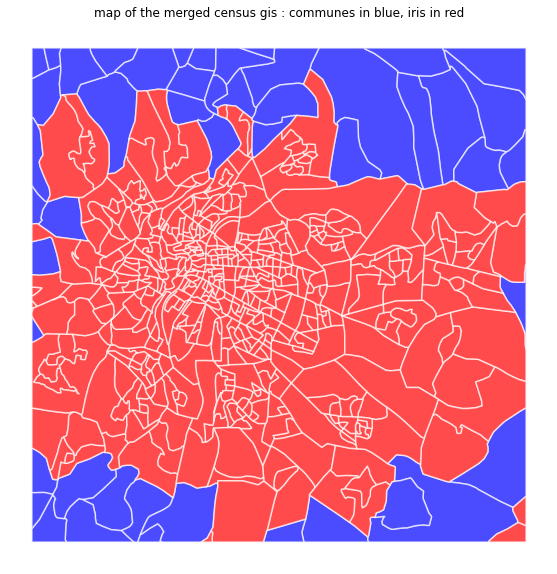

In [32]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
iris_commune.plot(ax=ax, column='is_iris', cmap='bwr', alpha=0.7, edgecolor='w',linewidth=1.5)
ax.axis('off')
ax.set_title('map of the merged census gis : communes in blue, iris in red')
plt.show()

<a id='nearest_neighbors'></a>
## Getting nearest neighbor zone
* Useful for spatialisation : if some agents must move from an origin `o` at time `t` but no flow exist in the transition matrix, then we look at the flow from the nearest neighbor of `o`.
* In some extreme case the first neighbor may not be enough. We compute the list of all neighbors for each zone.
* [back to summary](#summary)

In [33]:
n_neigbors = 20
iris_commune['x'] = iris_commune.centroid.x
iris_commune['y'] = iris_commune.centroid.y

from sklearn.neighbors import kneighbors_graph
c=Chrono('Computing nearest neighbor...')
kng = kneighbors_graph(iris_commune[['x', 'y']].values, n_neigbors, mode='distance', include_self=False)
c.done()

06:45:40	Computing nearest neighbor...
00:00:00	Work complete !


In [34]:
kngarr = kng.toarray()
kngarr

array([[   0.        , 2290.68992087, 4232.69653133, ...,    0.        ,
           0.        ,    0.        ],
       [2290.68992087,    0.        , 6431.02615315, ...,    0.        ,
           0.        ,    0.        ],
       [4232.69653133,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
         708.08190379,  415.6096733 ],
       [   0.        ,    0.        ,    0.        , ...,  708.08190379,
           0.        , 1107.65875022],
       [   0.        ,    0.        ,    0.        , ...,  415.6096733 ,
        1107.65875022,    0.        ]])

In [35]:
indsort = np.argsort(kngarr,axis=1)[:,-n_neigbors:][:,::-1]
indsort

array([[308, 302, 184, ...,   7,   1,   6],
       [302, 308,   4, ...,   5,   0,   3],
       [324,  43, 320, ..., 327,   6,   4],
       ...,
       [360, 530, 105, ..., 522, 525, 537],
       [ 91, 419, 533, ..., 527, 519, 525],
       [413, 430, 534, ..., 522, 526, 535]])

In [36]:

c.tprint('Parsing...')
for neighbor_rank in range(n_neigbors):
    iris_commune['nearest_neighbor_{}'.format(neighbor_rank)] = iris_commune['iris_or_commune'].values[indsort[:,neighbor_rank]]
c.done()


00:00:00	Parsing...
00:00:00	Work complete !


In [37]:
iris_commune[iris_commune['iris_or_commune']=='693810304']

,iris_or_commune,frac_area,geometry,is_iris,commune,x,y,nearest_neighbor_0,nearest_neighbor_1,nearest_neighbor_2,...,nearest_neighbor_10,nearest_neighbor_11,nearest_neighbor_12,nearest_neighbor_13,nearest_neighbor_14,nearest_neighbor_15,nearest_neighbor_16,nearest_neighbor_17,nearest_neighbor_18,nearest_neighbor_19
359,693810304,1.0,"POLYGON ((3919144.150 2531565.229, 3919143.894...",True,69381,3.919000e+06,2.531492e+06,693840302,693850101,693860104,...,693860201,693840203,693810303,693810101,693810501,693810302,693810102,693810301,693810201,693810202


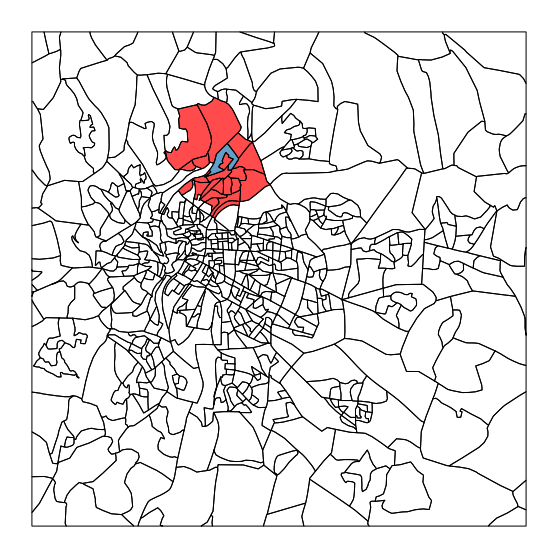

In [38]:
i = 89
fig, ax = plt.subplots(figsize=(10, 10))
iris_commune.boundary.plot(ax=ax, color='k',linewidth=1)
iris_commune[iris_commune.index==i].plot(ax=ax, alpha=0.7)
iris_commune[iris_commune.index.isin(indsort[i])].plot(ax=ax, alpha=0.7, color='r')
ax.axis('off')
plt.show()


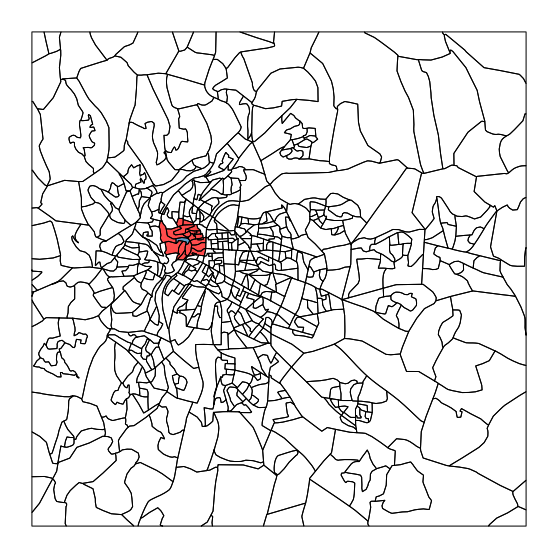

In [39]:

target_iris = '693850101'
target_iris_df = iris_commune[iris_commune['iris_or_commune'] == target_iris]
fig, ax = plt.subplots(figsize=(10, 10))
iris_commune.boundary.plot(ax=ax, color='k',linewidth=1)
target_iris_df.plot(ax=ax, alpha=0.7)
iris_commune[iris_commune.index.isin(indsort[target_iris_df.index[0]])].plot(ax=ax, alpha=0.7, color='r')
ax.axis('off')
plt.show()

<a id='gis_export'></a>
## Exporting GIS
* [back to summary](#summary)

In [1]:

gis_out_path = os.path.join(config['outdata_dir']['path'], 
                         config['outdata_dir']['gis_map_filename'])

print('Exporting to: {}'.format(gis_out_path))
iris_commune['wkt'] = iris_commune['geometry'].to_wkt()
iris_commune = iris_commune.drop(columns=['geometry'])
iris_commune.to_csv(gis_out_path, index=False)
iris_commune.head()
# Reading example :
# iris_commune=gpd.read_file(os.path.join(config['outdata_dir']['path'],config['outdata_dir']['gis_map_filename']))


NameError: name 'os' is not defined